In [1]:
#ライブラリインポート
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import lightgbm as lgb
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Pandasでの表示が省略されないように設定
pd.set_option("max_columns", 1000)
pd.set_option('max_rows',1000)
pd.set_option('max_info_columns',1000)

# Jupyterの枠を広げる
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:96%!important;}</style>"))

In [2]:
#全データ読み込み
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")
match_df = pd.read_csv("Data/match_reports.csv")
holiday_df = pd.read_csv("Data/holidays_in_japan.csv")
stadium_df = pd.read_csv("Data/stadium_capacity_mapping.csv")
smpsb_df = pd.read_csv("Data/sample_submit.csv", header=None)

representive_df = pd.read_csv("Data/representive_total.csv", header=None)
representive_df.columns=['representive_num']

representive_one_hot = pd.read_csv("Data/representive_total_one_hot.csv", header=None)
representive_one_hot.columns=['representive_one_hot']

distance_df = pd.read_csv("Data/distance.csv", header=None)
distance_df.columns=['distance']

home_rank_df = pd.read_csv("Data/home_team_rank.csv", header=None)
home_rank_df.columns=['home_rank']

away_rank_df = pd.read_csv("Data/away_team_rank.csv", header=None)
away_rank_df.columns=['away_rank']

home_rank_weekly_df = pd.read_csv("Data/home_team_rank_per_week.csv", header=None)
home_rank_weekly_df.columns=['home_rank_w']

away_rank_weekly_df = pd.read_csv("Data/away_team_rank_per_week.csv", header=None)
away_rank_weekly_df.columns=['away_rank_w']

home_katitenn_df = pd.read_csv("Data/home_team_score_katitenn.csv", header=None)
home_katitenn_df.columns=['home_katitenn']

away_katitenn_df = pd.read_csv("Data/away_team_score_katitenn.csv", header=None)
away_katitenn_df.columns=['away_katitenn']

# train, testなどの読み込んだデータは変更しない大元データとして取っておく
train_cp = train.copy()
test_cp = test.copy()
match_df_cp = match_df.copy()
holiday_df_cp = holiday_df.copy()
stadium_df_cp = stadium_df.copy()

In [3]:
# versionの確認
%load_ext watermark
%watermark -u -d -v -iv

re          2.2.1
numpy       1.14.3
pandas      0.22.0
seaborn     0.8.1
lightgbm    2.1.2
scipy       1.0.0
xgboost     0.71
last updated: 2018-12-07 

CPython 3.6.6
IPython 6.5.0


In [4]:
# trainとtestのデータフレームをマージ
target = train_cp["attendance"]
total_df = pd.concat([train_cp.drop("attendance", axis=1), test_cp])

In [5]:
total_df.head()

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters
0,9190,2006-03-04,16:04,第1節,第1日,G大阪,浦和,万博記念競技場,晴,8.3,40.0,NHK総合/J SPORTS(録)
1,9191,2006-03-05,13:00,第1節,第2日,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28.0,山梨放送/テレビ静岡(録)/J SPORTS(録)
2,9192,2006-03-05,13:35,第1節,第2日,FC東京,大分,味の素スタジアム,晴,12.1,35.0,BS-i/MXテレビ(録)/J SPORTS(録)
3,9193,2006-03-05,14:04,第1節,第2日,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42.0,J SPORTS
4,9194,2006-03-05,14:04,第1節,第2日,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32.0,スカイパーフェクTV!/NHK名古屋(録)/NHK大阪(録)/J SPORTS(録)


In [6]:
#match_df_cpにhome_team,away_teamのcolumnを追加
match_df_cp = match_df_cp.merge(right=total_df[["id","home_team","away_team"]],
                          how="left",
                          left_on="id",
                          right_on="id")

In [7]:
# 日時データ（match_date, kick_off_time, holiday_date）をdatetime型に変換
total_df.loc[:, "match_date"] = pd.to_datetime(total_df["match_date"])
total_df.loc[:, "kick_off_time"] = pd.to_datetime(total_df["kick_off_time"])
holiday_df_cp["holiday_date"] = pd.to_datetime(holiday_df_cp["holiday_date"])

#年、月、日、曜日のcolumnを追加
total_df["match_date_year"] = total_df["match_date"].dt.year
total_df["match_date_month"] = total_df["match_date"].dt.month
total_df["match_date_day"] = total_df["match_date"].dt.day
total_df["match_date_dayofweek"] = total_df["match_date"].dt.dayofweek  # Monday=0, Sunday=6

# 祝日の判定のcolumnを追加
holiday_df_cp["match_date_is_holiday"] = 1
total_df = total_df.merge(right=holiday_df_cp[["holiday_date", "match_date_is_holiday"]],
                          how="left",
                          left_on="match_date",
                          right_on="holiday_date").drop("holiday_date", axis=1)
total_df["match_date_is_holiday"].fillna(0, inplace=True)
#"kick_off_time"を"kick_off_time_hour"と"kick_off_time_minute"に分けたcolumn追加
total_df["kick_off_time_hour"] = total_df["kick_off_time"].dt.hour
total_df["kick_off_time_minute"] = total_df["kick_off_time"].dt.minute
#section,roundを数値データに変換
total_df.loc[:, "section"] = total_df.loc[:, "section"].apply(lambda x: int(x[1:-1]))
total_df.loc[:, "round"] = total_df.loc[:, "round"].apply(lambda x: int(x[1:-1]))

# 両年とも（本来の）18節は7月からなので、7月からのsectionを+17する
sec_index = total_df.query("(match_date_year in [2015, 2016])&(match_date_month >= 7)").index
total_df.loc[sec_index, "section"] = total_df.loc[sec_index, "section"] + 17

In [8]:
# チーム名の半角・全角の揺れを確認（G大阪、C大阪、川崎Fに揺れがある）
teams = set(total_df["home_team"].unique().tolist() + total_df["away_team"].unique().tolist())
# 全角・半角の揺れを修正し、まとめて置き換える関数を定義
def make_zen2han_dic(iterable):
    zen = list("ＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺ" +
               "ａｂｃｄｅｆｇｈｉｊｋｌｍｎｏｐｑｒｓｔｕｖｗｘｙｚ" +
               "０１２３４５６７８９，、．。（）＿−　")
    han = list("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789,,..()_- ")
    z2h = {}
    pattern = "|".join(zen)
    for it in iterable:
        if re.search(pattern, it) is None:
            continue
        target = it*1
        for z, h in zip(zen, han):
            target = target.replace(z, h)
        z2h[it] = target
    return z2h
#置き換える
z2h = make_zen2han_dic(teams)
total_df["home_team"].replace(z2h, inplace=True)
total_df["away_team"].replace(z2h, inplace=True)
teams = set(total_df["home_team"].unique().tolist() + total_df["away_team"].unique().tolist())

#home, awayにわけないパターン
for team in teams:
    total_df["team_" + team] = (total_df["home_team"] == team) | (total_df["away_team"] == team)

In [9]:
#重要ダービー（埼玉ダービー、大阪ダービー）の変数を作成
total_df["important_derby"] = 0
for i in range(len(total_df["important_derby"])):
    if (total_df.loc[i,'team_大宮']) & (total_df.loc[i,'team_浦和']):
        total_df.loc[i,["important_derby"]] = 1
    elif (total_df.loc[i,'team_C大阪']) & (total_df.loc[i,'team_G大阪']):
        total_df.loc[i,["important_derby"]] = 1
    else:
        total_df.loc[i,["important_derby"]] = 0
total_df["important_derby"] = total_df["important_derby"].astype('uint8')

In [10]:
#venueのキャパをstudiamを参照して調べてtotal_dfにキャパのcolumnを追加する
total_df = total_df.merge(right=stadium_df_cp,
                          how="left",
                          left_on="venue",
                          right_on="stadium").drop("stadium", axis=1)

In [11]:
# broadcastersのcolumnを綺麗にする
dirty_casters = set()
for casters in total_df["broadcasters"].str.split("/"):
    dirty_casters.update(casters)
clean_casters = set()
# ()と※より後ろを消す
# 小文字を大文字に統一
# ーを-に変換する
# スカパー派生は全てスカパーに統一

def cleanify(caster):
    caster = caster.upper()
    caster = re.sub("\(.+\)|\*", "", caster)
    caster = caster.split("※")[0]\
               .rstrip(" ")\
               .replace("ー", "-")\
               .replace(" ", "_")
    if caster[:4] == "スカパ-":
        caster = "スカパー"
    return caster

for caster in dirty_casters:
    clean_casters.add(cleanify(caster))

#broadcastersのcolumnを綺麗にする
tmp = total_df["broadcasters"].str.split("/")\
                              .apply(lambda casters: [cleanify(caster) for caster in casters])
total_df["broadcasters"] = tmp

#broadcasterごとにcolumn作ってbool値で埋める
for caster in clean_casters:
    total_df["broadcasters_{}".format(caster)] = total_df["broadcasters"].apply(lambda casters: caster in casters)

In [12]:
# 選手名とかポジションの処理は簡単にはいかないので、一旦点数と勝敗だけいれる
match_df_cp["home_team_win"] = match_df_cp["home_team_score"] > match_df_cp["away_team_score"]
total_df = total_df.merge(match_df_cp[["id", "home_team_win", "home_team_score", "away_team_score"]],
                          how="left",
                          on="id")

In [13]:
# 欠損値はいったん考えないこととする
total_df = total_df.dropna()

In [14]:
#意味わからん天気とかを天気データをもとに修正
# "曇時々晴のち屋内" を "屋内" に変換
total_df.loc[199,'weather']="屋内"
#観客が少ないわけでもないから"霧"→ "曇" に変換
total_df.loc[753,'weather']="曇"
#"雪系"天気データをもとに変換
total_df.loc[2751,'weather']="晴"
total_df.loc[2142,'weather']="晴"
total_df.loc[932,'weather']="曇"
total_df.loc[322,'weather']="曇"
#"曇晴"→実際は"曇"だから"曇"にする
total_df.loc[3406,'weather']="曇"
#"雷系"→"雨"
total_df.loc[493,'weather'] ="雨"
total_df.loc[780,'weather'] ="雨"
total_df.loc[782,'weather'] ="雨"
total_df.loc[795,'weather'] ="雨"
total_df.loc[2058,'weather'] ="雨"
total_df.loc[2787,'weather'] ="雨"
total_df.loc[3570,'weather'] ="雨"
# "曇時々晴のち屋内" を "屋内" に変換
total_df.loc[123,'weather']="屋内"
# "曇のち霧" を "曇" に変換
total_df.loc[3537,'weather']="曇"

In [15]:
#シンプルに単語を含んでいるか否かで判定(BoWみたい)
for condition in ["晴", "曇", "雨", "屋内", "のち", "時々", "一時"]:
    total_df["weather_{}".format(condition)] = total_df["weather"].str.contains(condition)

In [16]:
#.apply()でデータフレーム全体を引数に渡したversion
#.apply()を用いて判定match_date_dayofweek'
def is_sun_sat_hol(row):
    if row["match_date_dayofweek"] == 6:
        return 1
    elif row["match_date_dayofweek"] == 5:
        return 1
    elif row["match_date_is_holiday"]==1.0:
        return 1
    else:
        return 0
total_df["is_sun_sat_hol"]=total_df.apply(is_sun_sat_hol,axis=1)

In [17]:
#.apply()でデータフレームのカラムの１つを引数に渡したversion
'''
#.apply()を用いて判定
def is_sun_sat(row):
    if day_of_week == 6:
        return 1
    elif day_of_week == 5:
        return 1
    else:
        return 0
total_df["is_sun_sat_hol_ap"] = total_df["match_date_is_holiday"].apply(is_hol)
'''

'\n#.apply()を用いて判定\ndef is_sun_sat(row):\n    if day_of_week == 6:\n        return 1\n    elif day_of_week == 5:\n        return 1\n    else:\n        return 0\ntotal_df["is_sun_sat_hol_ap"] = total_df["match_date_is_holiday"].apply(is_hol)\n'

In [18]:
#土曜、日曜、祝日なら１その他の曜日なら０の"is_sun_sat_hol"カラムを作成(日曜だけで見るより、土日祝で見た休日の方が傾向が顕著に見られる)
'''
total_df['is_sun_sat_hol'] = 0
for i in range(len(total_df['match_date_dayofweek'])):
    if total_df.loc[i,'match_date_dayofweek'] == 6:
        total_df.loc[i,['is_sun_sat_hol']] = 1
    elif total_df.loc[i,'match_date_dayofweek'] == 5:
        total_df.loc[i,['is_sun_sat_hol']] = 1
    elif total_df.loc[i,"match_date_is_holiday"] == 1.0:
        total_df.loc[i,['is_sun_sat_hol']] = 1
    else:
        total_df.loc[i,['is_sun_sat_hol']] = 0
total_df['is_sun_sat_hol'] = total_df['is_sun_sat_hol'].astype('uint8')
'''

'\ntotal_df[\'is_sun_sat_hol\'] = 0\nfor i in range(len(total_df[\'match_date_dayofweek\'])):\n    if total_df.loc[i,\'match_date_dayofweek\'] == 6:\n        total_df.loc[i,[\'is_sun_sat_hol\']] = 1\n    elif total_df.loc[i,\'match_date_dayofweek\'] == 5:\n        total_df.loc[i,[\'is_sun_sat_hol\']] = 1\n    elif total_df.loc[i,"match_date_is_holiday"] == 1.0:\n        total_df.loc[i,[\'is_sun_sat_hol\']] = 1\n    else:\n        total_df.loc[i,[\'is_sun_sat_hol\']] = 0\ntotal_df[\'is_sun_sat_hol\'] = total_df[\'is_sun_sat_hol\'].astype(\'uint8\')\n'

In [19]:
# (lll) ホームチームのJリーグ加盟年のデータを自分で作成し、その値から'year'の数値を引いて、ホームチームの歴史を数値化する
df_history = pd.DataFrame({"team_name":['新潟', '横浜FC', '湘南', '清水', '浦和', '仙台', 'C大阪', '神戸', '広島', '福岡', '千葉', '鳥栖', '長崎', '大宮', '横浜FM', '甲府', '大分', 'G大阪', '京都', '名古屋', '東京V', '磐田', '徳島', '鹿島', '松本', 'FC東京', '札幌', '川崎F', '柏', '山形']})

df_history["join_year"]=3000

df_history.loc[0,"join_year"]=1999#
df_history.loc[1,"join_year"]=2001#
df_history.loc[2,"join_year"]=1994#
df_history.loc[3,"join_year"]=1992#
df_history.loc[4,"join_year"]=1992#
df_history.loc[5,"join_year"]=1999#
df_history.loc[6,"join_year"]=1995#
df_history.loc[7,"join_year"]=1997#
df_history.loc[8,"join_year"]=1992#
df_history.loc[9,"join_year"]=1996#
df_history.loc[10,"join_year"]=1992#
df_history.loc[11,"join_year"]=1999#
df_history.loc[12,"join_year"]=2013#
df_history.loc[13,"join_year"]=1999#
df_history.loc[14,"join_year"]=1992#途中で統合してるからその年からの場合1999(どっちが良い精度か確かめても良いかも)
df_history.loc[15,"join_year"]=1999#
df_history.loc[16,"join_year"]=1999#
df_history.loc[17,"join_year"]=1992#
df_history.loc[18,"join_year"]=1996#
df_history.loc[19,"join_year"]=1992#
df_history.loc[20,"join_year"]=1992#
df_history.loc[21,"join_year"]=1994#
df_history.loc[22,"join_year"]=2005#
df_history.loc[23,"join_year"]=1992#
df_history.loc[24,"join_year"]=2012#
df_history.loc[25,"join_year"]=1999#
df_history.loc[26,"join_year"]=1998#
df_history.loc[27,"join_year"]=1999#
df_history.loc[28,"join_year"]=1995#
df_history.loc[29,"join_year"]=1999#

df_history['join_year'] = df_history['join_year'].astype('uint32')

#Jリーグ加盟してから何年たったか
df_history['home_team_history'] = 0
for i in range(len(df_history['home_team_history'])):
     df_history.loc[i,['home_team_history']] = 2018 - int(df_history.loc[i,['join_year']])
df_history['home_team_history'] = df_history['home_team_history'].astype('uint32')
#total_dfにマージ
total_df = total_df.merge(right=df_history[["team_name","join_year","home_team_history"]],
                          how="left",
                          left_on="home_team",
                          right_on="team_name").drop("team_name",axis=1)

In [20]:
# 今回は欠損値に関して考えないものとする
total_df = total_df.dropna()
bool_col = total_df.filter(regex="^weather_").columns.tolist() + ["home_team_win"]
total_df.loc[:, bool_col] = total_df.loc[:, bool_col].astype(np.bool8)
# objectとdatetimeは直接扱えないので取り除く(match_date ,kick_off_time ,home_team,away_team,venue ,weather,broadcasters)
del_col = total_df.select_dtypes(["object", np.datetime64]).columns
total_df.drop(del_col, axis=1, inplace=True)

In [21]:
#A->B->Cの順で代表選手数増えてく
#代表選手の人数がA(０〜２),B(3〜5),C(6〜)でエンコーディング
representive_df["class"] = ""
for i in range(len(representive_df["class"])):
    if representive_df.loc[i,"representive_num"] > 5 :
        representive_df.loc[i,["class"]] = "C"
    elif (representive_df.loc[i,"representive_num"] <= 5) & (representive_df.loc[i,"representive_num"] > 2) :
        representive_df.loc[i,["class"]] = "B"
    elif representive_df.loc[i,"representive_num"] <= 2 :
        representive_df.loc[i,["class"]] = "A"

#人数のスケールと整数を対応させる辞書を生成
scale_mapping = {'A':1, 'B':2, 'C':3}
# マッピングの実行
representive_df['class'] = representive_df['class'].map(scale_mapping)

In [22]:
'''
#代表選手の人数を表すデータフレームと結合
total_df = pd.concat([total_df,representive_df],axis=1).drop("class",axis=1)
'''

'\n#代表選手の人数を表すデータフレームと結合\ntotal_df = pd.concat([total_df,representive_df],axis=1).drop("class",axis=1)\n'

In [23]:
#距離を表すデータフレームと結合
total_df = pd.concat([total_df,distance_df],axis=1)
total_df = total_df.dropna()

In [24]:
#homeチームのランクを表すデータフレームと結合
total_df = pd.concat([total_df,home_rank_df],axis=1)
total_df = total_df.dropna()

In [25]:
#awayチームのランクを表すデータフレームと結合
total_df = pd.concat([total_df,away_rank_df],axis=1)
total_df = total_df.dropna()

In [26]:
#homeチームのランクを表すデータフレームと結合
total_df = pd.concat([total_df,home_rank_weekly_df],axis=1)
total_df = total_df.dropna()

In [27]:
#awayチームのランクを表すデータフレームと結合
total_df = pd.concat([total_df,away_rank_weekly_df],axis=1)
total_df = total_df.dropna()

In [28]:
#homeチームの勝ち点を表すデータフレームと結合
#total_df = pd.concat([total_df,home_katitenn_df],axis=1)
#total_df = total_df.dropna()

In [29]:
#awayチームの勝ち点を表すデータフレームと結合
#total_df = pd.concat([total_df,away_katitenn_df],axis=1)
#total_df = total_df.dropna()

In [30]:
total_df.head()

,id,section,round,temperature,humidity,match_date_year,match_date_month,match_date_day,match_date_dayofweek,match_date_is_holiday,kick_off_time_hour,kick_off_time_minute,team_大宮,team_柏,team_松本,team_FC東京,team_神戸,team_横浜FC,team_浦和,team_広島,team_山形,team_新潟,team_仙台,team_川崎F,team_福岡,team_名古屋,team_C大阪,team_東京V,team_鳥栖,team_京都,team_長崎,team_G大阪,team_大分,team_甲府,team_札幌,team_千葉,team_清水,team_湘南,team_鹿島,team_徳島,team_横浜FM,team_磐田,important_derby,capacity,broadcasters_E2スカチャン,broadcasters_東北放送,broadcasters_NHK秋田,broadcasters_ミヤギテレビ,broadcasters_NHK徳島,broadcasters_NHK岩手,broadcasters_新潟放送,broadcasters_新潟テレビ21,broadcasters_テレビ神奈川,broadcasters_BS-I,broadcasters_NHK水戸,broadcasters_千葉テレビ,broadcasters_MXテレビ,broadcasters_J_SPORTS,broadcasters_北海道放送,broadcasters_NHK札幌,broadcasters_スカパー,broadcasters_J_SPORTS_ESPN,broadcasters_大分朝日放送,broadcasters_NHK静岡,broadcasters_TVK,broadcasters_東海テレビ,broadcasters_名古屋テレビ,broadcasters_日本テレビ,broadcasters_静岡第一テレビ,broadcasters_中京テレビ,broadcasters_NHK名古屋,broadcasters_NHK津,broadcasters_朝日放送,broadcasters_BS-TBS,broadcasters_DAZN,broadcasters_ひかりTV,broadcasters_NHK神戸,broadcasters_テレビ信州,broadcasters_NHK佐賀,broadcasters_テレ玉,broadcasters_北海道テレビ放送,broadcasters_BS,broadcasters_東日本放送,broadcasters_RKB毎日放送,broadcasters_テレビ北海道,broadcasters_NHK福島,broadcasters_北海道テレビ,broadcasters_静岡朝日テレビ,broadcasters_NHK大阪,broadcasters_NHK-BSハイビジョン,broadcasters_サンテレビ,broadcasters_テレビ静岡,broadcasters_NHK青森,broadcasters_福岡放送,broadcasters_九州朝日放送,broadcasters_NHK_BS1,broadcasters_テレビ大阪,broadcasters_J_SPORTS2,broadcasters_長崎国際テレビ,broadcasters_NHK甲府,broadcasters_NHK新潟,broadcasters_NHK総合,broadcasters_NHK広島,broadcasters_TOKYO_MX,broadcasters_関西テレビ,broadcasters_毎日放送,broadcasters_山梨放送,broadcasters_仙台放送,broadcasters_NHK京都,broadcasters_信越放送,broadcasters_KBS京都,broadcasters_NHK大分,broadcasters_スカイパ-フェクTV!,broadcasters_TVQ九州放送,broadcasters_札幌テレビ,broadcasters_TOKYO_MX2,broadcasters_テレビ山梨,broadcasters_E2スカチャンHD,broadcasters_テレビ埼玉,broadcasters_新潟総合テレビ,broadcasters_NHK長崎,broadcasters_札幌テレビ放送,broadcasters_テレビ大分,broadcasters_中部日本放送,broadcasters_NHK福岡,broadcasters_NHK長野,broadcasters_テレビ西日本,broadcasters_静岡放送,broadcasters_E2,broadcasters_長野朝日放送,broadcasters_テレビ新潟,broadcasters_中国放送,broadcasters_北海道文化放送,broadcasters_NHK岐阜,broadcasters_長野放送,broadcasters_NHK山形,broadcasters_NHK仙台,broadcasters_TBS,home_team_win,home_team_score,away_team_score,weather_晴,weather_曇,weather_雨,weather_屋内,weather_のち,weather_時々,weather_一時,is_sun_sat_hol,join_year,home_team_history,distance,home_rank,away_rank,home_rank_w,away_rank_w
0,9190.0,1.0,1.0,8.3,40.0,2006.0,3.0,4.0,5.0,0.0,16.0,4.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0.0,21000.0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,1.0,True,False,False,False,False,False,False,1.0,1992.0,26.0,399.258435,1.0,2.0,1.0,1.0
1,9191.0,1.0,2.0,12.9,28.0,2006.0,3.0,5.0,6.0,0.0,13.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,0.0,15859.0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,F

In [31]:
'''
#中立開催かどうかでone-hot
total_df["kokuritsu"] = 0
for i in range(len(total_df["kokuritsu"])):
    if total_df.loc[i,"capacity"] == 54224.0 :
        total_df.loc[i,["kokuritsu"]] = 1
    else:
         total_df.loc[i,["kokuritsu"]] = 0
total_df["kokuritsu"] = total_df["kokuritsu"].astype('uint32')
'''

'\n#中立開催かどうかでone-hot\ntotal_df["kokuritsu"] = 0\nfor i in range(len(total_df["kokuritsu"])):\n    if total_df.loc[i,"capacity"] == 54224.0 :\n        total_df.loc[i,["kokuritsu"]] = 1\n    else:\n         total_df.loc[i,["kokuritsu"]] = 0\ntotal_df["kokuritsu"] = total_df["kokuritsu"].astype(\'uint32\')\n'

In [32]:
#trainとtestに分ける
total_df = total_df.dropna()
train_df = total_df.query("id < 19075")
train_df.loc[:, "attendance"] = target.values
test_df = total_df.query("id >= 19075")

/Users/tuna0808/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/tuna0808/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [33]:
# 全体の1%に満たないbool値は消す
#threshold = 0.01
#bool_df = total_df.select_dtypes("bool")
#del_col = (bool_df.sum(axis=0)[bool_df.sum(axis=0) <= train_df.shape[0] * threshold]).index.tolist()
#total_df.drop(del_col, axis=1, inplace=True)
#print(del_col)

# NHK総合以外のテレビ局のみを消したい場合（チームとか）はこっちのコード
total_df = total_df.drop(columns=["broadcasters_日本テレビ","broadcasters_NHK岩手","broadcasters_E2","broadcasters_NHK名古屋","broadcasters_NHK-BSハイビジョン","broadcasters_北海道テレビ","broadcasters_仙台放送","broadcasters_福岡放送","broadcasters_TOKYO_MX","broadcasters_TOKYO_MX2","broadcasters_静岡第一テレビ","broadcasters_名古屋テレビ","broadcasters_山梨放送","broadcasters_関西テレビ","broadcasters_BS-TBS","broadcasters_NHK津","broadcasters_北海道放送","broadcasters_テレビ埼玉","broadcasters_J_SPORTS2","broadcasters_テレビ静岡","broadcasters_BS-I","broadcasters_NHK広島","broadcasters_NHK大分","broadcasters_北海道テレビ放送","broadcasters_NHK長野","broadcasters_信越放送","broadcasters_NHK長崎","broadcasters_静岡朝日テレビ","broadcasters_NHK札幌","broadcasters_TVQ九州放送","broadcasters_E2スカチャンHD","broadcasters_東海テレビ","broadcasters_長野放送","broadcasters_静岡放送","broadcasters_テレビ山梨","broadcasters_NHK岐阜","broadcasters_中京テレビ","broadcasters_テレビ信州","broadcasters_朝日放送","broadcasters_テレビ大阪","broadcasters_長野朝日放送","broadcasters_新潟総合テレビ","broadcasters_NHK秋田","broadcasters_毎日放送","broadcasters_テレビ大分","broadcasters_NHK仙台","broadcasters_新潟放送","broadcasters_TBS","broadcasters_NHK大阪","broadcasters_北海道文化放送","broadcasters_KBS京都","broadcasters_長崎国際テレビ","broadcasters_札幌テレビ放送","broadcasters_J_SPORTS_ESPN","broadcasters_テレビ新潟","broadcasters_RKB毎日放送","broadcasters_九州朝日放送","broadcasters_中国放送","broadcasters_NHK徳島","broadcasters_NHK山形","broadcasters_NHK福岡","broadcasters_J_SPORTS","broadcasters_東北放送","broadcasters_サンテレビ","broadcasters_DAZN","broadcasters_ミヤギテレビ","broadcasters_NHK京都","broadcasters_東日本放送","broadcasters_TVK","broadcasters_テレ玉","broadcasters_NHK新潟","broadcasters_札幌テレビ","broadcasters_NHK佐賀","broadcasters_NHK甲府","broadcasters_NHK水戸","broadcasters_NHK福島","broadcasters_新潟テレビ21","broadcasters_BS","broadcasters_NHK_BS1","broadcasters_E2スカチャン","broadcasters_テレビ北海道","broadcasters_MXテレビ","broadcasters_NHK静岡","broadcasters_NHK神戸","broadcasters_スカイパ-フェクTV!","broadcasters_NHK青森","broadcasters_千葉テレビ","broadcasters_テレビ神奈川","broadcasters_テレビ西日本","broadcasters_大分朝日放送","broadcasters_中部日本放送","broadcasters_ひかりTV","broadcasters_スカパー"])

In [34]:
len(total_df.columns)

63

In [35]:
total_df.head()

,id,section,round,temperature,humidity,match_date_year,match_date_month,match_date_day,match_date_dayofweek,match_date_is_holiday,kick_off_time_hour,kick_off_time_minute,team_大宮,team_柏,team_松本,team_FC東京,team_神戸,team_横浜FC,team_浦和,team_広島,team_山形,team_新潟,team_仙台,team_川崎F,team_福岡,team_名古屋,team_C大阪,team_東京V,team_鳥栖,team_京都,team_長崎,team_G大阪,team_大分,team_甲府,team_札幌,team_千葉,team_清水,team_湘南,team_鹿島,team_徳島,team_横浜FM,team_磐田,important_derby,capacity,broadcasters_NHK総合,home_team_win,home_team_score,away_team_score,weather_晴,weather_曇,weather_雨,weather_屋内,weather_のち,weather_時々,weather_一時,is_sun_sat_hol,join_year,home_team_history,distance,home_rank,away_rank,home_rank_w,away_rank_w
0,9190.0,1.0,1.0,8.3,40.0,2006.0,3.0,4.0,5.0,0.0,16.0,4.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0.0,21000.0,True,False,1.0,1.0,True,False,False,False,False,False,False,1.0,1992.0,26.0,399.258435,1.0,2.0,1.0,1.0
1,9191.0,1.0,2.0,12.9,28.0,2006.0,3.0,5.0,6.0,0.0,13.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,0.0,15859.0,False,False,0.0,2.0,True,False,False,False,False,False,False,1.0,1999.0,19.0,71.435209,-1.0,14.0,1.0,1.0
2,9192.0,1.0,2.0,12.1,35.0,2006.0,3.0,5.0,6.0,0.0,13.0,35.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0.0,48999.0,False,True,2.0,0.0,True,False,False,False,False,False,False,1.0,1999.0,19.0,772.935275,10.0,11.0,1.0,1.0
3,9193.0,1.0,2.0,11.6,42.0,2006.0,3.0,5.0,6.0,0.0,14.0,4.0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0.0,51697.0,False,False,1.0,1.0,True,False,False,False,False,False,False,1.0,1994.0,24.0,704.065706,6.0,-1.0,1.0,1.0
4,9194.0,1.0,2.0,13.1,32.0,2006.0,3.0,5.0,6.0,0.0,14.0,4.0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,20223.0,False,True,3.0,2.0,True,False,False,False,False,False,False,1.0,1992.0,26.0,163.143955,14.0,5.0,1.0,1.0


In [36]:
#trainデータに目的変数のattendanceをマージ
#無観客試合のインデックスを削除
total_df = total_df.dropna()
train_df = total_df.query("id < 19075")
train_df.loc[:, "attendance"] = target.values
train_df.drop(2479, inplace=True)  # 無観客試合
test_df = total_df.query("id >= 19075")

/Users/tuna0808/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/tuna0808/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/tuna0808/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [37]:
# 今回は時系列データなので、ある期間との前後でデータを分ける
# 2015年までのデータを訓練データ
# 2016年のデータを検証用データにする
all_train_X = train_df.query("match_date_year <= 2016").drop(["id", "attendance"], axis=1)
all_train_y = train_df.query("match_date_year <= 2016")["attendance"]

train_X = train_df.query("match_date_year <= 2015").drop(["id", "attendance"], axis=1)
train_y = train_df.query("match_date_year <= 2015")["attendance"]

val_X = train_df.query("match_date_year == 2016").drop(["id", "attendance"], axis=1)
val_y = train_df.query("match_date_year == 2016")["attendance"]

test_X = test_df.drop(["id"], axis=1)

In [38]:
# LASSO回帰を実行
from sklearn.linear_model import Lasso                         # LASSO回帰のクラスを読み込み
model_lasso = Lasso(alpha=1000)                                # LASSO回帰のインスタンスを生成
model_lasso.fit(train_X, train_y)                                      # データを学習させる

Lasso(alpha=1000, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [39]:
model_lasso.coef_

array([ 8.65246442e+01,  0.00000000e+00,  0.00000000e+00, -2.87451267e+01,
       -9.92528909e+00,  0.00000000e+00, -2.21476076e+01,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  2.29623523e+01, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  3.87371649e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -

<Container object of 62 artists>

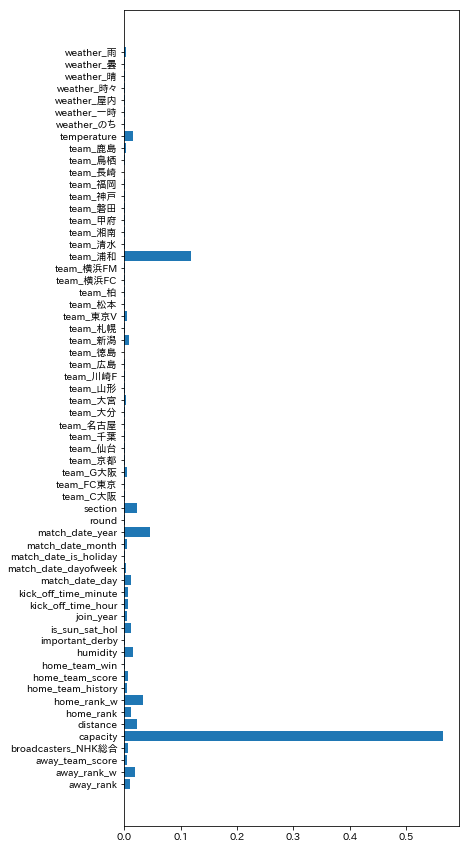

In [40]:
# 一旦feauture importance見てみる
rfr = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=2434)
rfr.fit(train_X, train_y)
train_pred = rfr.predict(train_X)
val_pred = rfr.predict(val_X)

plt.figure(figsize=(6, 15))
plt.barh(train_X.columns, rfr.feature_importances_)

In [41]:
total_df.to_csv("total_df.csv")
train_df.to_csv("train_df.csv")
test_df.to_csv("test_df.csv")